# EEG to ECG Reconstruction


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae


seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.7.1+cu126
CUDA version: 12.6
Tesla T4
Using device: cuda


In [13]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]
test_subj = subj_all[0]
val_subj = subj_all[1]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = True
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.8
batch_size = 16
learning_rate = 1e-3
epochs = 200
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed.pkl")

## Load, Parse and Preprocess

Loaded parsed and preprocess data from cache


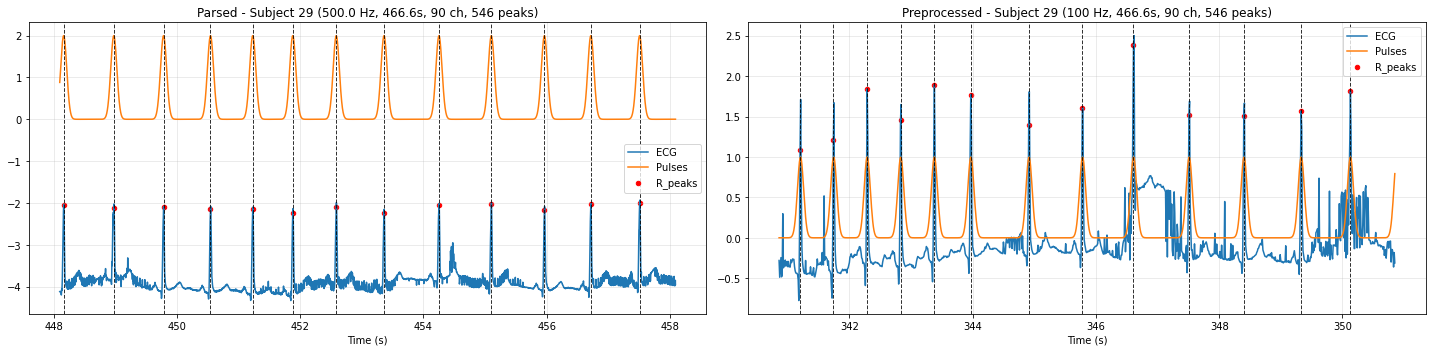

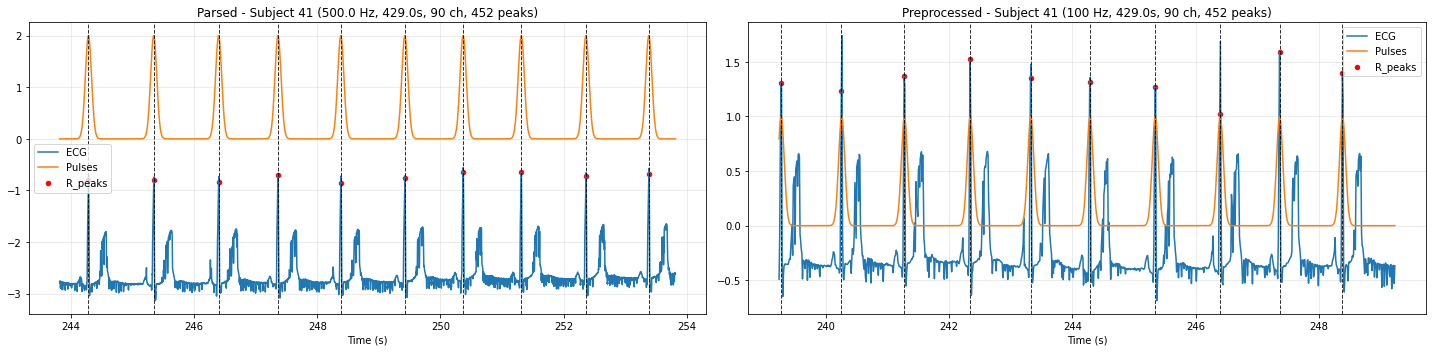

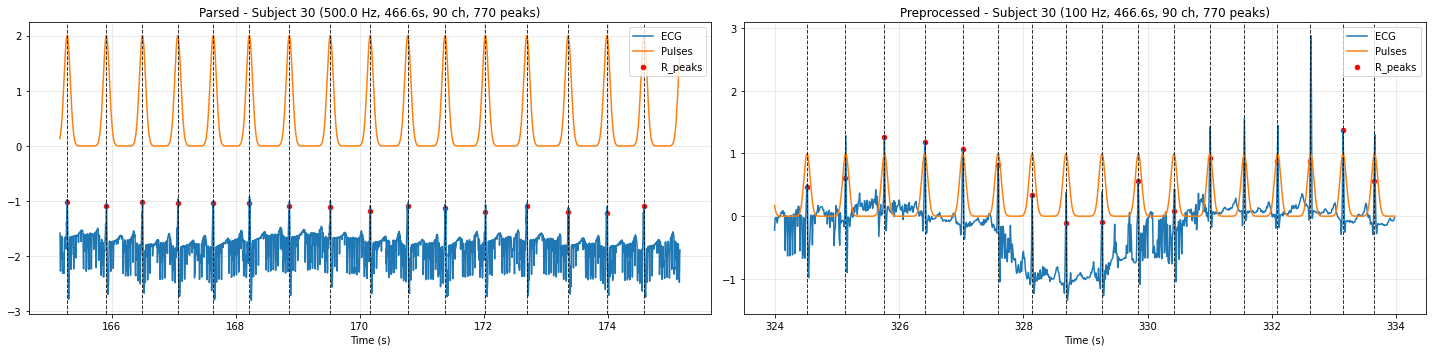

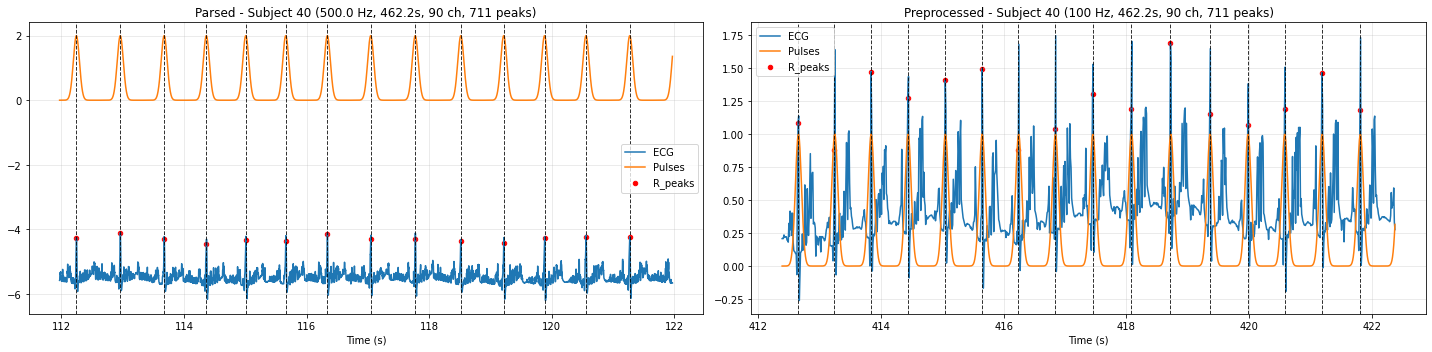

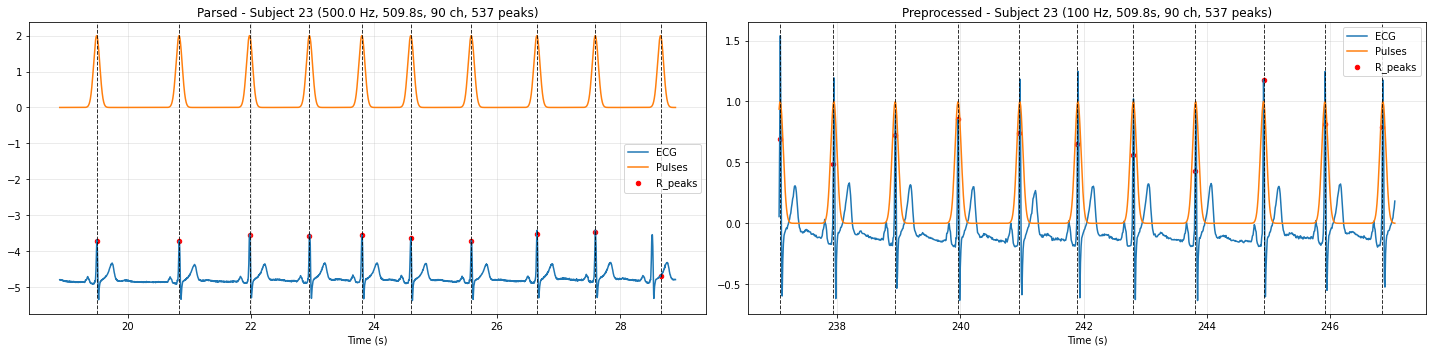

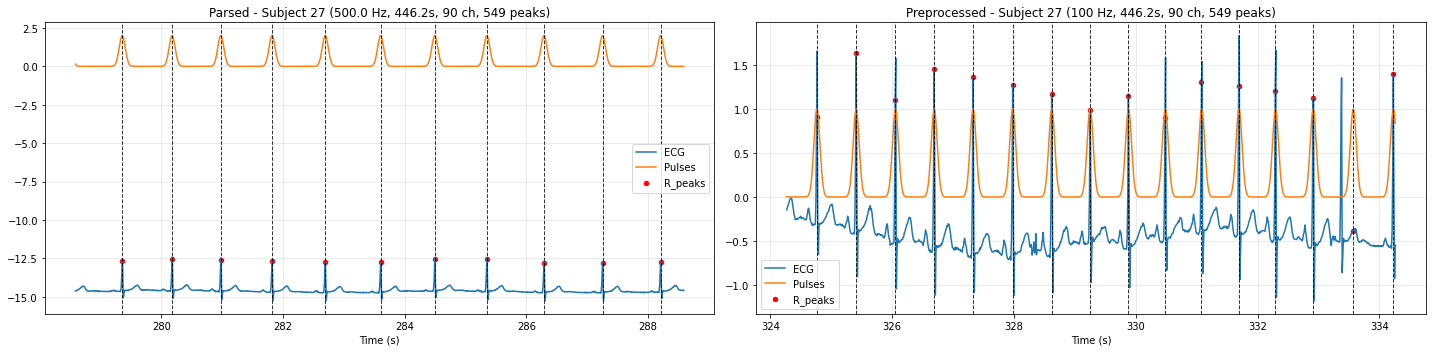

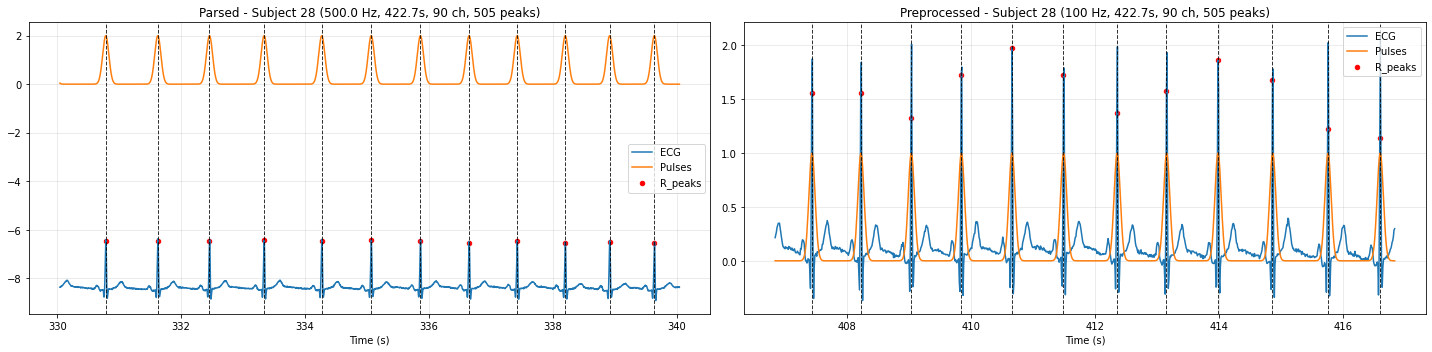

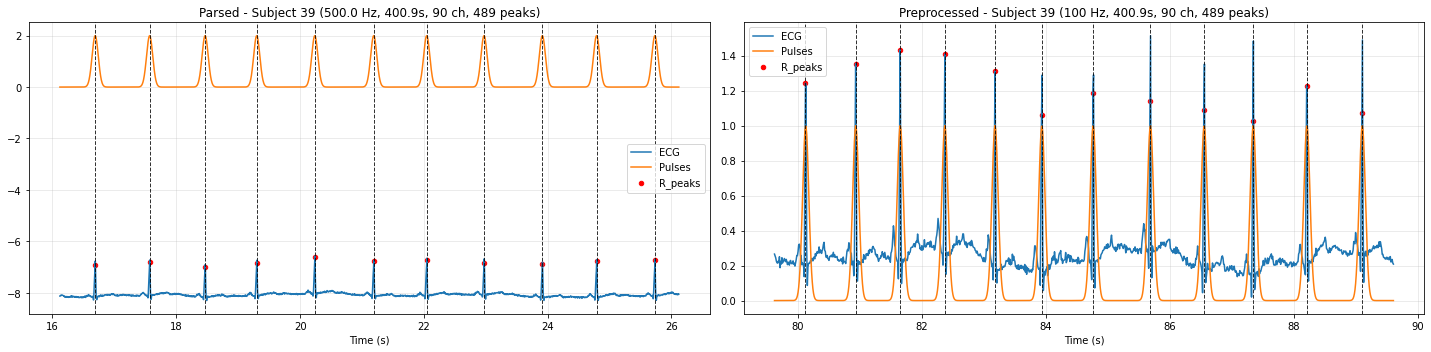

In [14]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]
    freq = int(subject_data['freq'] / tau)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peaks, 'EEG': EEG, 'time': time, 'freq': freq }


# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}

    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")

    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Visualize parsed data
for ss in subj_all:
    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

## Segmentation and Train/Val/Test Split

In [15]:
downsampled_frequency = data_preprocessed[subj_all[0]]['freq']
seg_len = int(duration_sec * downsampled_frequency)
aug_seg_len = int(aug_segment_duration * downsampled_frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

print(f"Test subject: {test_subj} | Val subject: {val_subj} | Train subject: {train_subjects}")
print(f"Frequency: {downsampled_frequency} Hz | Segment length: {seg_len} samples ({duration_sec}s)")
print(f"Train overlap: {train_overlap:.2f}")

if use_augmentation:
    print(f"Augmentation: {n_augmented_per_segment}x per segment")
    print(f"Warp range: {warp_factor_range}")

Test subject: 29 | Val subject: 41 | Train subject: [30, 40, 23, 27, 28, 39]
Frequency: 100 Hz | Segment length: 1000 samples (10s)
Train overlap: 0.80
Augmentation: 5x per segment
Warp range: (0.85, 1.15)


In [16]:
X_train_list, y_train_list, ecg_train_list, train_ids_list = [], [], [], []

for s in train_subjects:
    print(f"Processing training subject {s}...", end="")
    
    if use_augmentation:
        X_s, y_s, ecg_s = create_training_segments_with_augmentation(
            data_preprocessed[s], aug_seg_len, seg_len, train_stride,
            warp_factor_range, n_augmented_per_segment
        )
        print(f"  Created {X_s.shape[0]} segments (with augmentation)")
    else:
        X_s, y_s, ecg_s = create_segments_sliding(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len, train_stride
        )
        print(f"  Created {X_s.shape[0]} segments")
    
    X_train_list.append(X_s)
    y_train_list.append(y_s)
    ecg_train_list.append(ecg_s)
    train_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# Build validation set (non-overlapping)
print(f"\nProcessing validation subject {val_subj}...", end="")
X_val, y_val, ECG_val = create_segments_nonoverlapping(
    data_preprocessed[val_subj]['EEG'],
    data_preprocessed[val_subj]['ECG_pulse'],
    data_preprocessed[val_subj]['ECG'],
    seg_len
)
print(f"  Created {X_val.shape[0]} segments")

# Build test set (non-overlapping)
print(f"Processing test subject {test_subj}...", end="")
X_test, y_test, ECG_test = create_segments_nonoverlapping(
    data_preprocessed[test_subj]['EEG'],
    data_preprocessed[test_subj]['ECG_pulse'],
    data_preprocessed[test_subj]['ECG'],
    seg_len
)
print(f"  Created {X_test.shape[0]} segments")

# Concatenate training data
X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, seg_len, n_channels))
y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0, seg_len))
ECG_train = np.concatenate(ecg_train_list, axis=0) if ecg_train_list else np.empty((0, seg_len))
train_seg_subjects = np.concatenate(train_ids_list, axis=0) if train_ids_list else np.empty((0,), dtype=np.int32)

print(f"\nFinal dataset:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

Processing training subject 30...  Created 1374 segments (with augmentation)
Processing training subject 40...  Created 1362 segments (with augmentation)
Processing training subject 23...  Created 1506 segments (with augmentation)
Processing training subject 27...  Created 1314 segments (with augmentation)
Processing training subject 28...  Created 1242 segments (with augmentation)
Processing training subject 39...  Created 1176 segments (with augmentation)

Processing validation subject 41...  Created 42 segments
Processing test subject 29...  Created 46 segments

Final dataset:
  Train: (7974, 1000, 90)
  Val: (42, 1000, 90)
  Test: (46, 1000, 90)


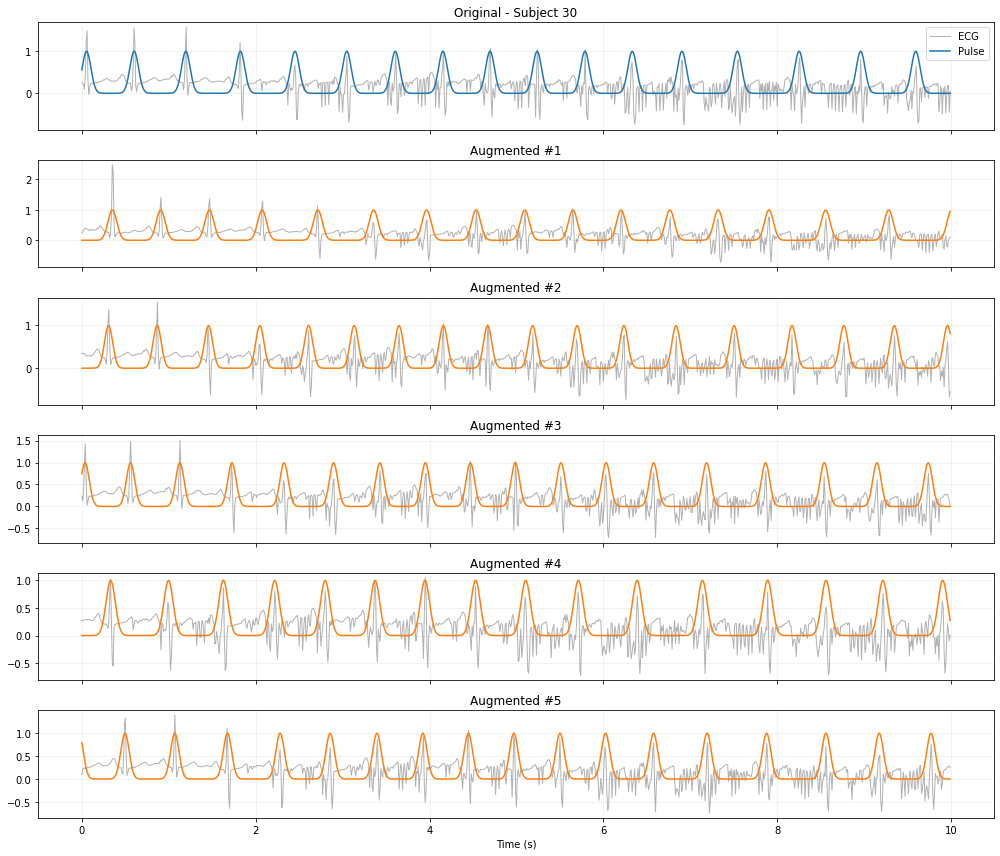

In [17]:
# Visualize augmentation example
if use_augmentation and len(train_subjects) > 0:
    demo_subj = train_subjects[0]
    plot_augmentation_example(data_preprocessed, demo_subj, aug_seg_len, seg_len, warp_factor_range, downsampled_frequency)

In [18]:
# Create PyTorch datasets and loaders
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={batch_size}")

Created data loaders with training batch_size=16


## Model Definition

In [19]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()

    def forward(self, x):
        return self.dropout(self.net(x))


class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=32, out_ch=1, dropout=0.2):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch, dropout)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, dropout)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, dropout)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, dropout)
        self.up2 = nn.ConvTranspose1d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, dropout)
        self.up1 = nn.ConvTranspose1d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, dropout)

        self.out_conv = nn.Conv1d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, C) -> (B, C, T)
        
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        out = self.out_conv(d1)  # (B, 1, T)
        return out.squeeze(1)  # (B, T)


model = UNet1D(in_ch=n_channels, base_ch=8, out_ch=1, dropout=0.5).to(device)

summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 1000, 90]             [1, 1000]                 --
├─ConvBlock: 1-1                         [1, 90, 1000]             [1, 8, 1000]              --
│    └─Sequential: 2-1                   [1, 90, 1000]             [1, 8, 1000]              --
│    │    └─Conv1d: 3-1                  [1, 90, 1000]             [1, 8, 1000]              2,168
│    │    └─BatchNorm1d: 3-2             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-3                    [1, 8, 1000]              [1, 8, 1000]              --
│    │    └─Conv1d: 3-4                  [1, 8, 1000]              [1, 8, 1000]              200
│    │    └─BatchNorm1d: 3-5             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-6                    [1, 8, 1000]              [1, 8, 1000]              --
│    └─Dropout: 2-2            

## Training

Starting training...
Epoch 01 - train: 0.23283, val: 0.21746, test: 0.21952
Epoch 02 - train: 0.22084, val: 0.19966, test: 0.21024
Epoch 03 - train: 0.19610, val: 0.19501, test: 0.20162
Epoch 04 - train: 0.18233, val: 0.19765, test: 0.20635
Epoch 05 - train: 0.17317, val: 0.19520, test: 0.20009
Epoch 06 - train: 0.16850, val: 0.19525, test: 0.20078
Epoch 07 - train: 0.16664, val: 0.20215, test: 0.20413
Epoch 08 - train: 0.16400, val: 0.20147, test: 0.20732
Epoch 09 - train: 0.16294, val: 0.18458, test: 0.18530
Epoch 10 - train: 0.16184, val: 0.19892, test: 0.20005
Epoch 11 - train: 0.16077, val: 0.19843, test: 0.19730
Epoch 12 - train: 0.16007, val: 0.20178, test: 0.19744
Epoch 13 - train: 0.15943, val: 0.20064, test: 0.20227
Epoch 14 - train: 0.15861, val: 0.19836, test: 0.19765
Epoch 15 - train: 0.15790, val: 0.20363, test: 0.19743
Epoch 16 - train: 0.15741, val: 0.20360, test: 0.19808
Epoch 17 - train: 0.15692, val: 0.20159, test: 0.19757
Epoch 18 - train: 0.15656, val: 0.20027, tes

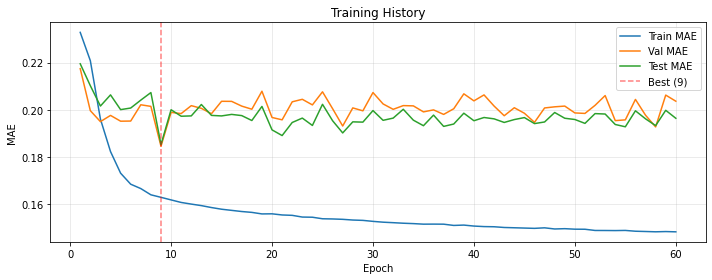

In [20]:
from lib.train_utils import check_early_stopping


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_mae_hist, val_mae_hist, test_mae_hist = [], [], []
best_val = float('inf')
best_state = None
wait = 0
best_epoch = 0

print("Starting training...")
for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss, train_mae, n_batches = 0.0, 0.0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += (pred.detach() - yb).abs().mean().item()
        n_batches += 1
    
    train_loss /= n_batches
    train_mae /= n_batches

    # Evaluate
    val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
    test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

    # Log
    train_mae_hist.append(train_mae)
    val_mae_hist.append(val_mae)
    test_mae_hist.append(test_mae)
    print(f"Epoch {epoch:02d} - train: {train_mae:.5f}, val: {val_mae:.5f}, test: {test_mae:.5f}")

    stopping, best_val, best_state, best_epoch, wait = check_early_stopping(epoch, val_mae, best_val, wait, patience, model, best_state, best_epoch)
    if stopping:
        break
    
# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Restored best model from epoch {best_epoch}")

plot_train_hystory(train_mae_hist, val_mae_hist, test_mae_hist, best_epoch)

## Evaluation and Visualization

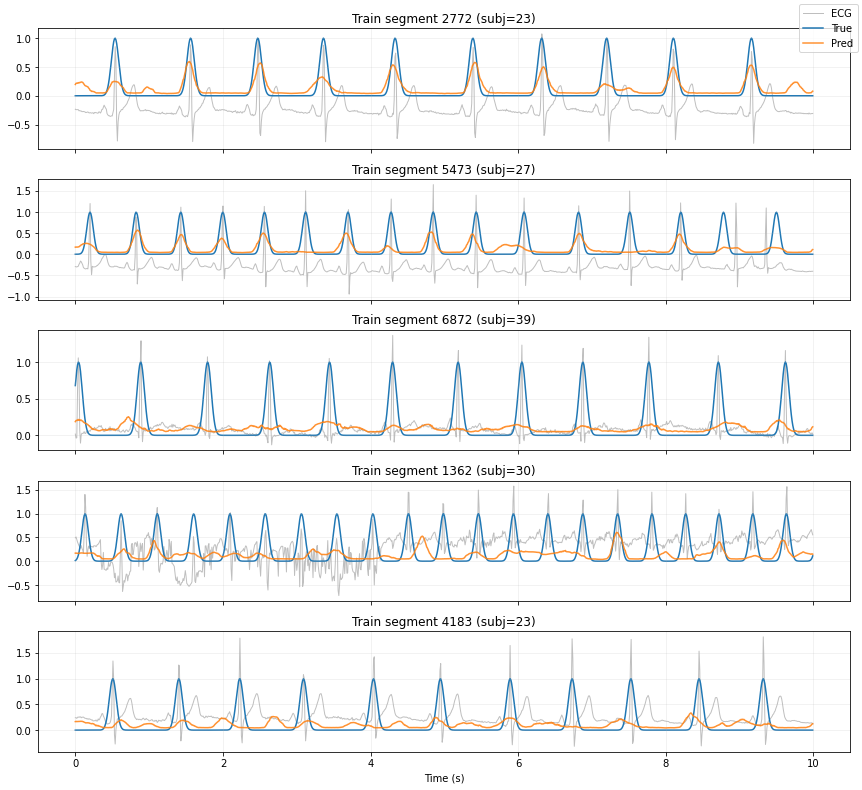

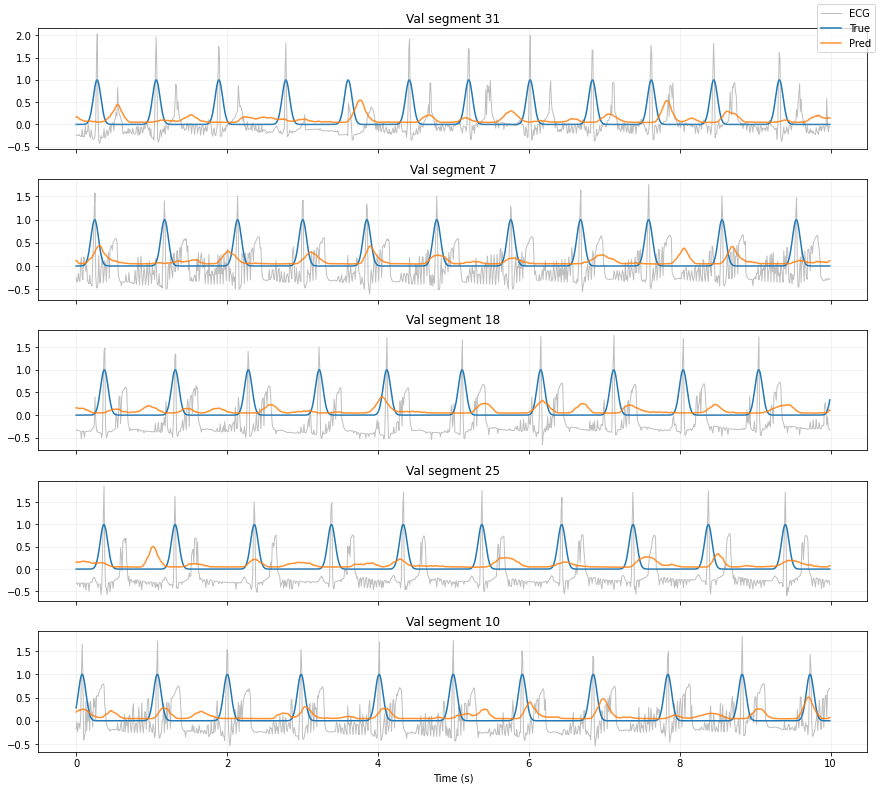

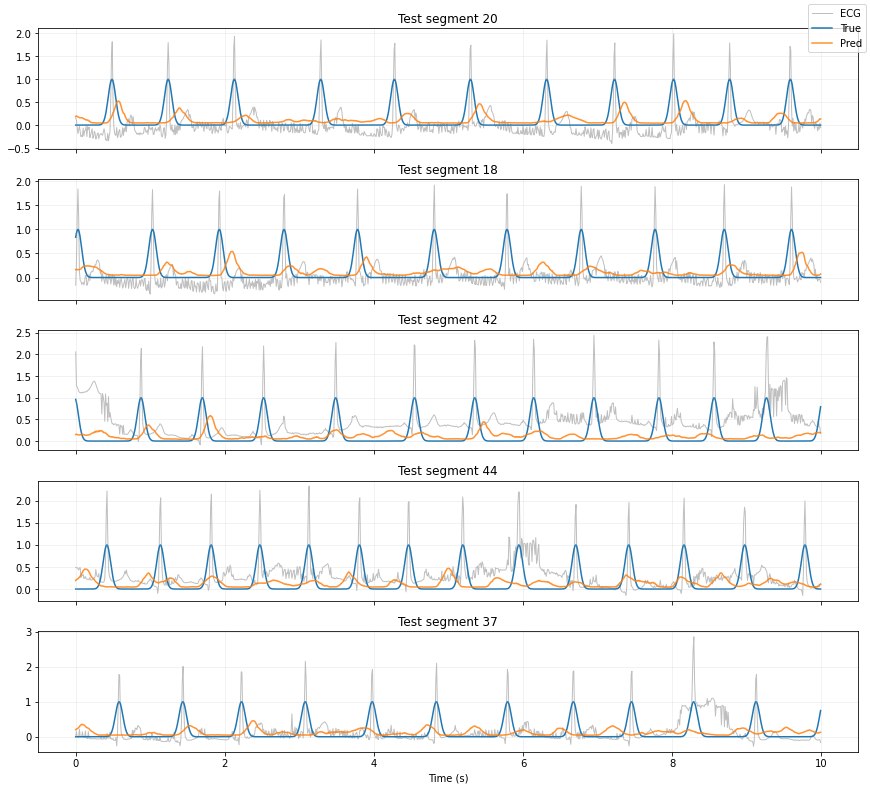

In [21]:
visualize_predictions('Train', X_train, y_train, ECG_train, model, seg_len, downsampled_frequency, device, train_seg_subjects, k=5)
visualize_predictions('Val', X_val, y_val, ECG_val, model, seg_len, downsampled_frequency, device, k=5)
visualize_predictions('Test', X_test, y_test, ECG_test, model, seg_len, downsampled_frequency, device, k=5)

In [22]:
# Per-subject training MAE
subject_mae(model, train_seg_subjects, X_train, y_train, device)

# Final evaluation
val_loss, val_mae = evaluate_loader(model, val_loader, device, criterion)
test_loss, test_mae = evaluate_loader(model, test_loader, device, criterion)

print(f"\nFinal Results:")
print(f"  Val MAE:  {val_mae:.5f}")
print(f"  Test MAE: {test_mae:.5f}")


Per-subject Training MAE:
  Subject 23: MAE = 0.13778 (1506 segments)
  Subject 27: MAE = 0.12649 (1314 segments)
  Subject 28: MAE = 0.13835 (1242 segments)
  Subject 30: MAE = 0.15965 (1374 segments)
  Subject 39: MAE = 0.18076 (1176 segments)
  Subject 40: MAE = 0.14157 (1362 segments)

Final Results:
  Val MAE:  0.18458
  Test MAE: 0.18530
